# DistilBERT

In this project, we will assist students who are starting to learn text analysis. The main objective is to build language applications using Hugging Face and natural language processing with transformersn this project, we will assist students who are starting to learn text analysis. The main objective is to build language applications using Hugging Face and natural language processing with transformers.

## Statistical Analyses on Texts

The text analyses presented here are based on datasets available on the Hugging Face Hub (https://oreil.ly/959YT).

For the analyses we will develop here, we use the dataset available at https://huggingface.co/datasets/vamossyd/finance_emotions.

#### Importing libraries

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import list_datasets


#### Importing the dataset

In [22]:
emotions = load_dataset('emotion')
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Note that, the dataset is a dictionary partitioned between `train`, `test` and `validation`. 

We can use the usual dictionary syntax to acess an individual split.

In [23]:
X_train = emotions['train']
print(f'The length of the dataset train is {len(X_train)}')

# If we want to access the first information, we can do:
print(f'The first information is {X_train[0]}')

# If we want to see the column names, we can do:
print(f'The column names are {X_train.column_names}')

# If we want to see the attribute of dataset object, we can do:
print(f'Theattribute of dataset object are {X_train.features}')


The length of the dataset train is 16000
The first information is {'text': 'i didnt feel humiliated', 'label': 0}
The column names are ['text', 'label']
Theattribute of dataset object are {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


To develop our analyses, we will convert the dataset into a DataFrame.


In [24]:
emotions.set_format(type='pandas')
df_train = emotions['train'][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The column headers have been preserved, and the first few rows match our previous view of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the label feature to create a new column in our DataFrame with the corresponding label names.

In [25]:
def input_label(row):
    return emotions['train'].features['label'].int2str(row)

# Applying the function
df_train['label_name'] = df_train['label'].apply(input_label)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Let's check the class distribution

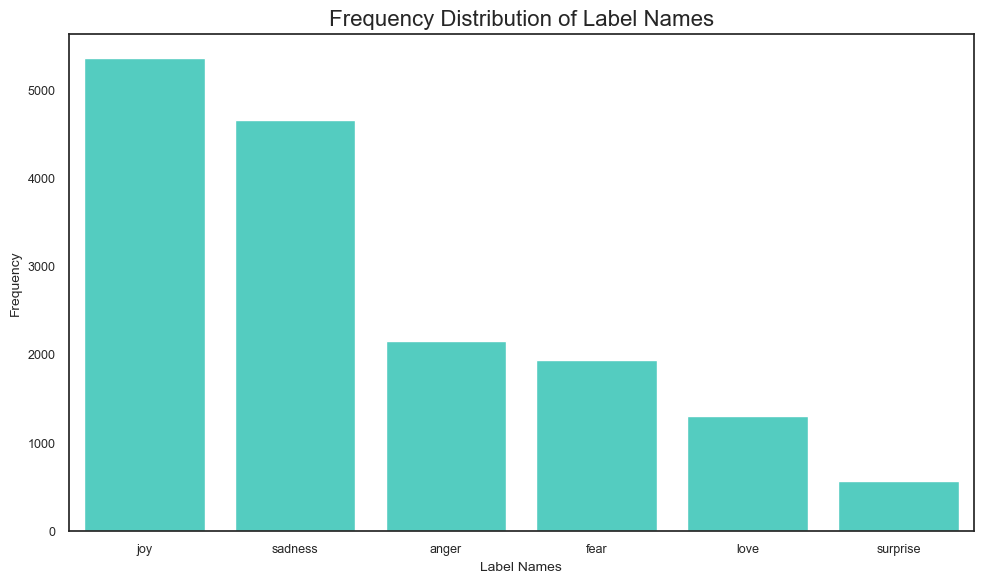

In [26]:
# Count the frequency of values in 'label_name'
label_counts = df_train['label_name'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, color='#40E0D0')
# Customize the chart
plt.title("Frequency Distribution of Label Names", fontsize=16)
plt.xlabel("Label Names", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Show the chart
plt.tight_layout()
plt.show()


Obviously, there are imbalanced classes: for example, **surprise**, **love**, **fear**, and **anger** are minority classes compared to **joy** and **sadness**.

At the present moment, we are working with imbalanced classes. If necessary, we will adjust the classes.

**Note**: For applications using DistilBERT, the maximum context size is $512$ tokens, wich amounts to a few paragraphs of text.

**Question:** Can we approximate tweet lengths for each emotion by analyzing the word distribution per tweet?

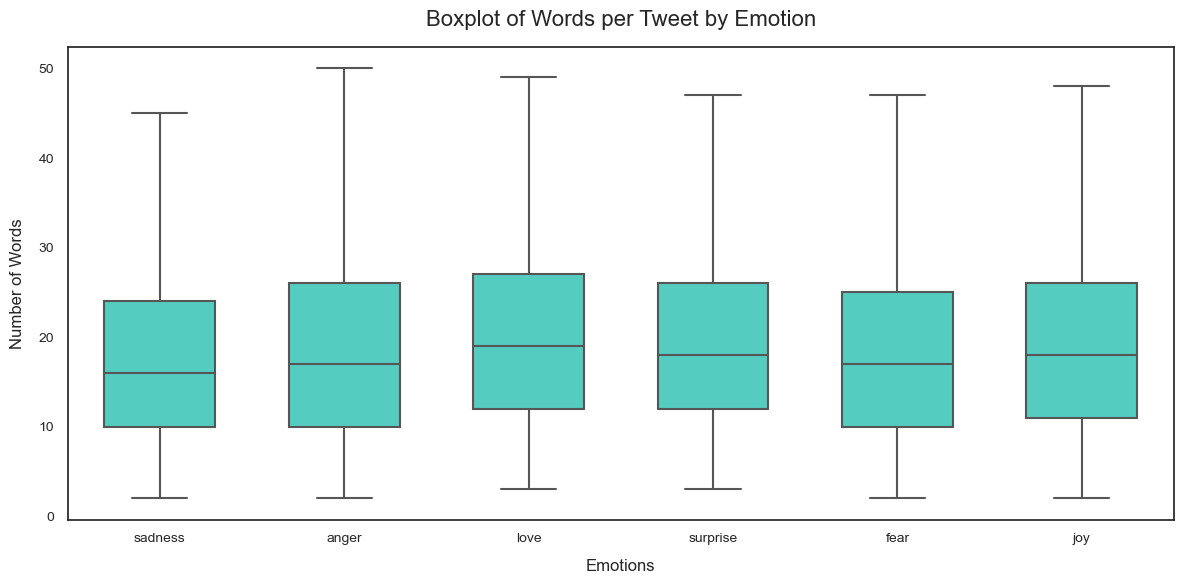

In [27]:
df_train['words_tweet'] = df_train['text'].str.split().apply(len)

sns.set_theme(style="white")  

# Create the improved boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='label_name', 
    y='words_tweet', 
    data=df_train, 
    color='#40E0D0',       
    showfliers=False,       
    width=0.6,             
    linewidth=1.5       
)

# Customize the title and labels
plt.title("Boxplot of Words per Tweet by Emotion", fontsize=16, pad=15)  
plt.xlabel("Emotions", fontsize=12, labelpad=10)                         
plt.ylabel("Number of Words", fontsize=12, labelpad=10)                  
plt.xticks(fontsize=10)                                                  
plt.yticks(fontsize=10)                                                  
plt.tight_layout()
plt.show()


Through the boxplot, we can see that for each emotion, the majority of tweets have around 15 words, and the other tweets are shorter than DistilBERT's maximum context size.
Texts longer than the model's context size must be truncated, which can result in performance degradation if the truncated text contains critical information. However, in this case, it does not appear to be an issue.

The next step is to transform the texts into tokens.









### What is a Token?

A **token** is a small piece of text that a computer can understand. When we give a sentence to a program, it breaks the sentence into smaller parts called tokens.

#### Examples:
1. **Full sentence:** "I like cats."
2. **Tokens (small parts):**
   - As words: `["I", "like", "cats"]`
   - As smaller pieces: `["I", "li", "ke", "ca", "ts"]`

The computer uses these tokens to turn text into numbers, because computers work with numbers, not words.

#### Why is this important?
Imagine teaching a robot to understand text. It can’t read full sentences like humans do. But if we split the sentence into tokens, the robot can learn what each piece means and how they connect to each other.

#### Simple Comparison:
Tokens are like puzzle pieces. Each piece alone doesn’t tell much, but when you put them together, they form the full picture (or the meaning of the text).


### Tokenization

The simplest tokenization method is to treat each character as a token and feed them individually to the model. In Python, `str` objects work like arrays internally, making it quick and easy to implement character-level tokenization.

Here is a simple example.

In [28]:
input_text = input('Insert a text:') #I love NLP.
print(input_text)

tokenized_text = list(input_text)
print(tokenized_text)

I love NLP!
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'N', 'L', 'P', '!']


All models expect each character to be converted into an integer, a process sometimes called **numericalization**.

We can perform **numericalization** as follows:

In [29]:
unique_chars = sorted(set(tokenized_text))
tokenized_idx = dict(zip(unique_chars, range(len(unique_chars))))
print(tokenized_idx)

{' ': 0, '!': 1, 'I': 2, 'L': 3, 'N': 4, 'P': 5, 'e': 6, 'l': 7, 'o': 8, 'v': 9}


Using **tokenized_idx** we can to transform the tokenized text to a list of integers. 

In [30]:
idx = [tokenized_idx[token] for token in tokenized_text]
print(idx)

[2, 0, 7, 8, 9, 6, 0, 4, 3, 5, 1]


Note that each token is associated with a unique numerical value. The final step is to convert the **idx** into a $2D$ tensor of one-hot encoded vectors.

### What is One-Hot Encoding?

A **one-hot encoded** representation is a way of converting categorical data (like words, characters, or labels) into a binary format that a machine learning model can process. It uses a vector where:

- **Only one position is "hot" (1):** The position corresponding to the category is set to `1`.
- **All other positions are "cold" (0):** All other positions are set to `0`.

#### Example

If you have three categories: `["cat", "dog", "fish"]`, each one can be represented as a vector in a one-hot encoded format:

- `cat` → `[1, 0, 0]`
- `dog` → `[0, 1, 0]`
- `fish` → `[0, 0, 1]`

The index of `1` corresponds to the category's position in the list.

#### Why is it Useful?

1. **Machine learning models:**  
   Models like neural networks work with numbers, not text, so one-hot encoding helps translate text into numerical input.

2. **No order imposed:**  
   One-hot encoding ensures that categories are treated as equally distinct, with no implied order or hierarchy.


### What is a Tensor?

A **tensor** is a mathematical object that is a generalization of scalars, vectors, and matrices to higher dimensions. It’s the fundamental building block in many machine learning and deep learning frameworks, such as TensorFlow and PyTorch.

#### Examples of Tensors by Dimension

- **0D Tensor (Scalar):** A single number.  
  Example: `5` or `3.14`
  
- **1D Tensor (Vector):** A one-dimensional array of numbers.  
  Example: `[1, 2, 3]`
  
- **2D Tensor (Matrix):** A two-dimensional array of numbers.  
  Example:  `[[1, 2, 3], [4, 5, 6]]`

- **3D Tensor:** A collection of matrices (like a cube of numbers).  
  Example: `[[[1, 2], [3, 4]], [[5, 6], [7, 8]]]`


- **nD Tensor:** Higher-dimensional arrays for more complex data representations.

#### Why are Tensors Important?

1. **Efficient Representation:**  
 Tensors allow us to represent and manipulate data of various shapes and dimensions in an efficient and structured way.

2. **Flexibility:**  
 Tensors can handle data like images, audio signals, or videos, which often require more than two dimensions.

3. **Foundation for Deep Learning:**  
 Operations like matrix multiplications, convolutions, and gradient calculations in neural networks are performed on tensors.

#### Analogy

Think of a tensor as a **generalized container** for data:
- A **0D tensor** is like a single number.
- A **1D tensor** is like a list of numbers (e.g., a shopping list).
- A **2D tensor** is like a spreadsheet.
- A **3D tensor** is like a stack of spreadsheets.

Tensors make it easy to store and process data for machine learning models.



In [31]:
import torch
import torch.nn.functional as F

# idx =[1, 0, 6, 7, 8, 5, 0, 3, 2, 4]
idx = torch.tensor(idx)
one_hot_enconding = F.one_hot(idx, num_classes=len(idx))
print(one_hot_enconding.shape)
one_hot_enconding

torch.Size([11, 11])


tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

----

#### Explaning the output


Tensor:
[
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # Represents index 1  
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Represents index 0  
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Represents index 6  
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Represents index 7  
  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # Represents index 8  
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # Represents index 5  
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Represents index 0  
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # Represents index 3  
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Represents index 2  
  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]   # Represents index 4  
]

----

From the simple example, we see that character-level tokenization ignores the structure of the text, treating it as a sequence of characters. While it helps handle misspellings and rare words, it requires significant resources since linguistic structures like words need to be learned from scratch.

For this reason, character tokenization is rarely used. Instead, approaches like word tokenization preserve the structure of the text more efficiently.

### Word Tokenization

Unlike character-level tokenization, which treats text as a sequence of characters, word tokenization preserves the natural linguistic structure, making it more intuitive for analyzing and processing textual data.

This method simplifies tasks like sentiment analysis, topic modeling, and text classification by focusing on meaningful units of language. While straightforward, word tokenization comes with challenges such as handling contractions, punctuation, and language-specific nuances. In this chapter, we will explore the principles, methods, and practical applications of word tokenization in NLP workflows.

A straightforward class of word tokenizers relies on whitespace to split the text into tokens. This method of tokenization can be easily implemented using the `split()` function.

In [32]:
tokenized_text = input_text.split()
print(tokenized_text)

['I', 'love', 'NLP!']


From here, we can follow the same steps presented earlier and map each word to a unique ID.

A major limitation of this tokenization scheme is that it does not handle punctuation properly, treating terms like NLP as a single token. Additionally, variations such as declensions, conjugations, and misspellings can significantly expand the vocabulary, easily reaching millions of unique tokens.

### Subword Tokenization

Subword tokenization is a technique that splits text into units smaller than whole words but larger than individual characters. The core idea is to strike a balance between character-level and word-level tokenization by breaking words into meaningful subparts or subwords. This approach helps address the limitations of traditional word and character tokenization, making it particularly effective in modern Natural Language Processing (NLP) models.

### Principles of Subword Tokenization

#### Handling Rare Words:
- Instead of treating rare or unknown words as separate tokens, subword tokenization breaks them into smaller, more common subunits.
- **For example:**
  - Rare word: `"unhappiness"`
  - Subwords: `["un", "happiness"]`

#### Combining Efficiency and Flexibility:
- **Common words** are kept intact:  
  `"cat"` → `["cat"]`
- **Uncommon or complex words** are split into smaller units:  
  `"internationalization"` → `["inter", "national", "ization"]`
- This reduces the vocabulary size while still capturing meaningful linguistic information.

#### Dealing with Misspellings and Variants:
- Words with spelling errors or slight variations can share similar subword components, making models more robust to noise.
- **Example:**  
  `"color"` and `"colour"` may share subunits like `["col", "or"]`.

#### Vocabulary Efficiency:
- Subword tokenization significantly reduces the vocabulary size compared to word-level tokenization, as the model doesn’t need to memorize every single word in the language.


**Note:** There are several subword tokenization algorithms that are commoly used in NLP, but let's start with `WordPiece`, wich is used by DistilBERT tokenizers.

In [33]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased' #the "uncased" version means that all letters will be treated as lowercase, ignoring case sensitivity.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) #Loads the tokenizer associated with the DistilBERT model.

The `AutoTokenizer` class is part of a broader family of **auto** classes designed to automatically retrieve a model's configuration, pretrained weights, or vocabulary based on the checkpoint name. This feature allows for seamless switching between models. However, if needed, you can also manually load a specific tokenizer class.

In [34]:
encoded_text = tokenizer(input_text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


### Example for a Hypothetical Text

For the text `"I love NLP!"` (based on DistilBERT's vocabulary), the tokenized output is:

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


#### Breakdown of `input_ids`:
- **101**: Special token `[CLS]`, added at the beginning of the text.
- **1045**: Token for `"I"`.
- **2293**: Token for `"love"`.
- **17953**: Token for `"NLP"`.
- **2361**: Token for `"!"`.
- **999**: Token representing an unknown word or character (likely unrecognized punctuation or symbol).
- **102**: Special token `[SEP]`, added at the end of the text.

---

### `attention_mask`

The `attention_mask` indicates which tokens are relevant and should be processed by the model:

- **1**: Indicates a relevant token (part of the actual input text).
- **0**: Indicates an ignored token (e.g., padding).

In this case, all mask values are `1` because the text does not require padding.


In [35]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]']
